In [36]:
import numpy as np
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, argmin, argmax, pi, mean, exp, sqrt, zeros, ones, nan
import scipy
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre
from numpy.polynomial import chebyshev

In [37]:
class MergedSol:
    def __init__(self, sol_r, sol_l):

        self.sol_r = sol_r
        self.sol_l = sol_l

        assert(abs(sol_r.t[-1] - sol_l.t[0]) < 1e-14)
        assert(abs(sol_r.t[0] - 1) < 1e-14)
        assert(abs(sol_l.t[-1] - 0) < 1e-14)

        self.bnd = sol_r.t[-1]

        self.y = np.concatenate((sol_r.y, sol_l.y), axis=1)
        print(self.y.shape)
        self.t = np.concatenate((sol_r.t, sol_l.t))

    def single_value(self, x):
        if x > self.bnd:
            return self.sol_r.sol(x)
        else:
            return self.sol_l.sol(x)

    def sol(self, x):
        if isinstance(x, np.ndarray):
            return np.array([self.single_value(x_) for x_ in x]).T
        else:
            return self.single_value(x)


In [ ]:
class PCSWE():

    def __init__(self):
        self.debug = False


        # geometry
        self.A = 0.72
        self.H = 7.12 
        self.L = 8e3

        # tunable
        self.r = 0.24
        self.h0 = 0.0025
        self.small_number = nan
        self.bc = nan
        # self.bc = self.bc_moving_boundary


        # morphodynamics
        self.p = 0.4 # porosity
        self.c_d = 0.0025
        self.lmbda = 6.8e-6
        self.d50 = 0.13e-3

        # universal constants
        self.g = 9.81
        self.sigma = 1.4e-4
        self.rho_w = 1025
        self.rho_s = 2650

        self.set_derivative_vars()
        
    def set_derivative_vars(self):
        self.epsilon = self.A / self.H
        self.eta = self.sigma * self.L / sqrt(self.g * self.H)
        self.U = self.epsilon * self.sigma * self.L
        self.kappa = self.g * self.H / (self.sigma * self.L) ** 2

        self.s = self.rho_s / self.rho_w

        self.delta = 0.04 * self.c_d**(3/2) * self.A * (self.sigma * self.L)**4 / \
                    (self.g**2 * (self.s-1)**2 * self.d50 * self.H**6 * (1-self.p))

    def h_fx(self, x): return x
    def h_fx_dx(self, x): return 1 * np.ones(np.array(x).shape)
    def h_fx_dxx(self, x): return 0
    def h_fx_dxxx(self, x): return 0
    
    def deriv_LO(self, x_x, y0_x):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)
        u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
        u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_LO_hop(self, x_x, y0_x):
        assert(x_x > 0.8)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)
        u0c_x_dx =  ( dz0s_x_dx - u0c_x * h_x_dxx)  / (2*h_x_dx)
        u0s_x_dx =  (-dz0c_x_dx - u0s_x * h_x_dxx)  / (2*h_x_dx)
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_FO(self, x_x, y1_x):

        y0_x = self.y0.sol(x_x)
        y0_x_dx = self.deriv_LO(x_x, y0_x)

        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx= self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x) - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x) - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x) - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa
        u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
        u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
        u1s_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1s_x + 2 * dz1c_x - 1 / 2 * (dz0s_x * u0c_x_dx + dz0s_x_dx * u0c_x + dz0c_x * u0s_x_dx + dz0c_x_dx * u0s_x))
        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 

    def deriv_FO_hop(self, x_x, y1_x):
        assert(x_x > 0.8)

        y0_x = self.y0.sol(x_x)

        if x_x > self.LO_bnd:
            y0_x_dx = self.deriv_LO_hop(x_x, y0_x)
        else:
            y0_x_dx = self.deriv_LO(x_x, y0_x)

        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx, h_x_dxxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x), self.h_fx_dxxx(x_x)

        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x) - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x) - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x) - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa
        
        # second derivatives of leading order components:
        dz0c_x_dxx = 1 / self.kappa * (- self.r / (1 - h_x + self.h0)**2 * h_x_dx * u0c_x - self.r / (1 - h_x + self.h0) * u0c_x_dx - u0s_x_dx)
        dz0s_x_dxx = 1 / self.kappa * (- self.r / (1 - h_x + self.h0)**2 * h_x_dx * u0s_x - self.r / (1 - h_x + self.h0) * u0s_x_dx + u0c_x_dx)
        u0c_x_dxx = 1/3 * (- h_x_dxx / h_x_dx**2 * ( dz0s_x_dx - u0c_x * h_x_dxx) + 1 / h_x_dx * ( dz0s_x_dxx - u0c_x_dx * h_x_dxx - u0c_x * h_x_dxxx))
        u0s_x_dxx = 1/3 * (- h_x_dxx / h_x_dx**2 * (-dz0c_x_dx - u0s_x * h_x_dxx) + 1 / h_x_dx * (-dz0c_x_dxx - u0s_x_dx * h_x_dxx - u0s_x * h_x_dxxx))

        # second derivatives of products of leading order components:
        dz_u_cc_x_dxx = (dz0c_x * u0c_x_dxx + 2 * dz0c_x_dx * u0c_x_dx + dz0c_x_dxx * u0c_x)
        dz_u_ss_x_dxx = (dz0s_x * u0s_x_dxx + 2 * dz0s_x_dx * u0s_x_dx + dz0s_x_dxx * u0s_x)
        dz_u_cs_x_dxx = (dz0s_x * u0c_x_dxx + 2 * dz0s_x_dx * u0c_x_dx + dz0s_x_dxx * u0c_x)
        dz_u_sc_x_dxx = (dz0c_x * u0s_x_dxx + 2 * dz0c_x_dx * u0s_x_dx + dz0c_x_dxx * u0s_x)

        # l'hopital
        u1r_x_dx = (             - u1r_x * h_x_dxx + (dz_u_cc_x_dxx + dz_u_ss_x_dxx) / 2) / (2*h_x_dx)
        u1c_x_dx = ( 2*dz1s_x_dx - u1c_x * h_x_dxx + (dz_u_cc_x_dxx - dz_u_ss_x_dxx) / 2) / (2*h_x_dx)
        u1s_x_dx = (-2*dz1c_x_dx - u1s_x * h_x_dxx + (dz_u_cs_x_dxx + dz_u_sc_x_dxx) / 2) / (2*h_x_dx)
        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 
   
    def y_r_LO(self, dz0_r):
        dz0c_r, dz0s_r = dz0_r
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx
        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r
        return y_r

    def y_r_FO(self, dz1_r):
        dz0c_r, dz0s_r, u0c_r, u0s_r = self.y0.y[:, -1]

        dz1r_r, dz1c_r, dz1s_r = dz1_r
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)

        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)
        # u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        # u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) - 2 * dz1s_r)
        # u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) + 2 * dz1c_r)
        u1r_r = (             - 1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))  / (-h_r_dx)
        u1c_r = (- 2 * dz1s_r - 1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r))  / (-h_r_dx)
        u1s_r = (+ 2 * dz1c_r - 1 / 2 * (dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r + dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r)) / (-h_r_dx)
        
        y_r = dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r
        return y_r
    

    def ivp_LO(self, dz0_r, dense_output=False):
        y0_r = self.y_r_LO(dz0_r)



        x_boundary = 1 - self.LO_bnd

        x_range = [1, x_boundary]

        sol0_r = scipy.integrate.solve_ivp(
            self.deriv_LO_hop,
            x_range,
            y0_r,
            rtol=1e-11,
            atol=1e-11,
            method='RK45',
            dense_output=dense_output
        )

        y_boundary = sol0_r.y[:, -1]

        x_range = [x_boundary, 0]
        sol0_l = scipy.integrate.solve_ivp(
            self.deriv_LO,
            x_range,
            y_boundary,
            rtol=1e-11,
            atol=1e-11,
            method='RK45',
            dense_output=dense_output
        )

        if dense_output:
            return sol0_r, sol0_l
        
        return sol0_l

    def ivp_FO(self, dz1_r, dense_output=False):
        y1_r = self.y_r_FO(dz1_r)

        x_boundary = 1 - self.FO_bnd

        x_range = [1, x_boundary]
        sol1_r = scipy.integrate.solve_ivp(
            self.deriv_FO_hop,
            x_range,
            y1_r,
            rtol=1e-7,
            atol=1e-7,
            method='RK45',
            dense_output=dense_output
        )

        y_boundary = sol1_r.y[:, -1]

        x_range = [x_boundary, 0]
        sol1_l = scipy.integrate.solve_ivp(
            self.deriv_FO,
            x_range,
            y_boundary,
            rtol=1e-7,
            atol=1e-7,
            method='RK45',
            dense_output=dense_output
        )
        

        if dense_output:
            return sol1_r, sol1_l
        
        return sol1_l

    def ivp_FO_pure_hop(self, y1_r, x_range = [1, 0.9]):

        sol1_r = scipy.integrate.solve_ivp(
            self.deriv_FO_hop,
            x_range,
            y1_r,
            rtol=1e-7,
            atol=1e-7,
            method='RK45'
        )

        return sol1_r
    
    def ivp_FO_pure_norm(self, y1_r, x_range = [0.99, 0.9]):

        sol1_r = scipy.integrate.solve_ivp(
            self.deriv_FO,
            x_range,
            y1_r,
            rtol=1e-7,
            atol=1e-7,
            method='RK45'
        )

        return sol1_r


    def solve_LO(self):
        
        def mismatch(dz0_r):
            sol = self.ivp_LO(dz0_r)
            dz0c_l, dz0s_l, u0c_l, u0s_l = sol.y[:, -1]
            return [dz0c_l - 1, dz0s_l]

        dz_guess = 0.001 * np.ones((2))
        res = scipy.optimize.root(mismatch, dz_guess)
        print(res)
        if res.status == 1:
            sol1, sol2 = self.ivp_LO(res.x, dense_output=True)
            return res, sol1, sol2
    
    def solve_FO(self):
        
        def mismatch(dz1_r):
            sol = self.ivp_FO(dz1_r)
            dz1r_l, dz1c_l, dz1s_l, u1r_l, u1c_l, u1s_l = sol.y[:, -1]
            return [dz1r_l, dz1c_l, dz1s_l]

        dz1_guess = 0.001 * np.ones((3))
        res = scipy.optimize.root(mismatch, dz1_guess)
        print(res)
        if res.status == 1:
            sol1, sol2 = self.ivp_FO(res.x, dense_output=True)
            return res, sol1, sol2
      

In [39]:
pcswe = PCSWE()
pcswe.h0 = 0.1
pcswe.r = 0.45
pcswe.small_number = 0
pcswe.tol = 1e-5
pcswe.set_derivative_vars()

pcswe.LO_bnd = 1e-8
res, sol0_r, sol0_l = pcswe.solve_LO()

pcswe.y0 = MergedSol(sol0_r, sol0_l)

print(sol0_l.t)
print(sol0_r.t)

 message: The solution converged.
 success: True
  status: 1
     fun: [-4.441e-16  7.752e-18]
       x: [ 1.018e+00  1.987e-02]
  method: hybr
    nfev: 10
    fjac: [[-9.998e-01  1.952e-02]
           [-1.952e-02 -9.998e-01]]
       r: [-9.822e-01  2.118e-07 -9.822e-01]
     qtf: [-3.671e-14 -7.636e-14]
(4, 47)
[0.99999999 0.99978144 0.99958218 0.99914494 0.99848379 0.99751439
 0.99617757 0.99440528 0.99212481 0.9892514  0.98567811 0.98125549
 0.97574563 0.96868366 0.95873682 0.9477831  0.93714566 0.92604343
 0.91423023 0.90158542 0.88801453 0.87342996 0.85774421 0.84086668
 0.82270182 0.80314789 0.78209589 0.75942877 0.73502052 0.70873534
 0.68042677 0.64993679 0.61709481 0.58171666 0.54360346 0.50254039
 0.45829542 0.41061789 0.35923697 0.30386004 0.24417089 0.1798278
 0.11046143 0.03567256 0.        ]
[1.         0.99999999]


 message: The solution converged.
 success: True
  status: 1
     fun: [-1.564e-18 -5.421e-19 -3.361e-17]
       x: [ 2.005e-04  1.732e-03 -3.742e-02]
  method: hybr
    nfev: 9
    fjac: [[-1.000e+00  1.620e-07  3.860e-07]
           [-1.465e-07 -9.992e-01  3.991e-02]
           [-3.922e-07 -3.991e-02 -9.992e-01]]
       r: [-1.000e+00  2.062e-07  3.233e-07 -9.297e-01  5.874e-08
           -9.297e-01]
     qtf: [ 2.220e-15 -1.436e-14 -1.687e-14]
[1.   0.99]
[0.99       0.98104907 0.97223302 0.95670372 0.92965524 0.89066478
 0.84300305 0.78151945 0.7011368  0.5948227  0.45255404 0.25981716
 0.        ]
(6, 15)


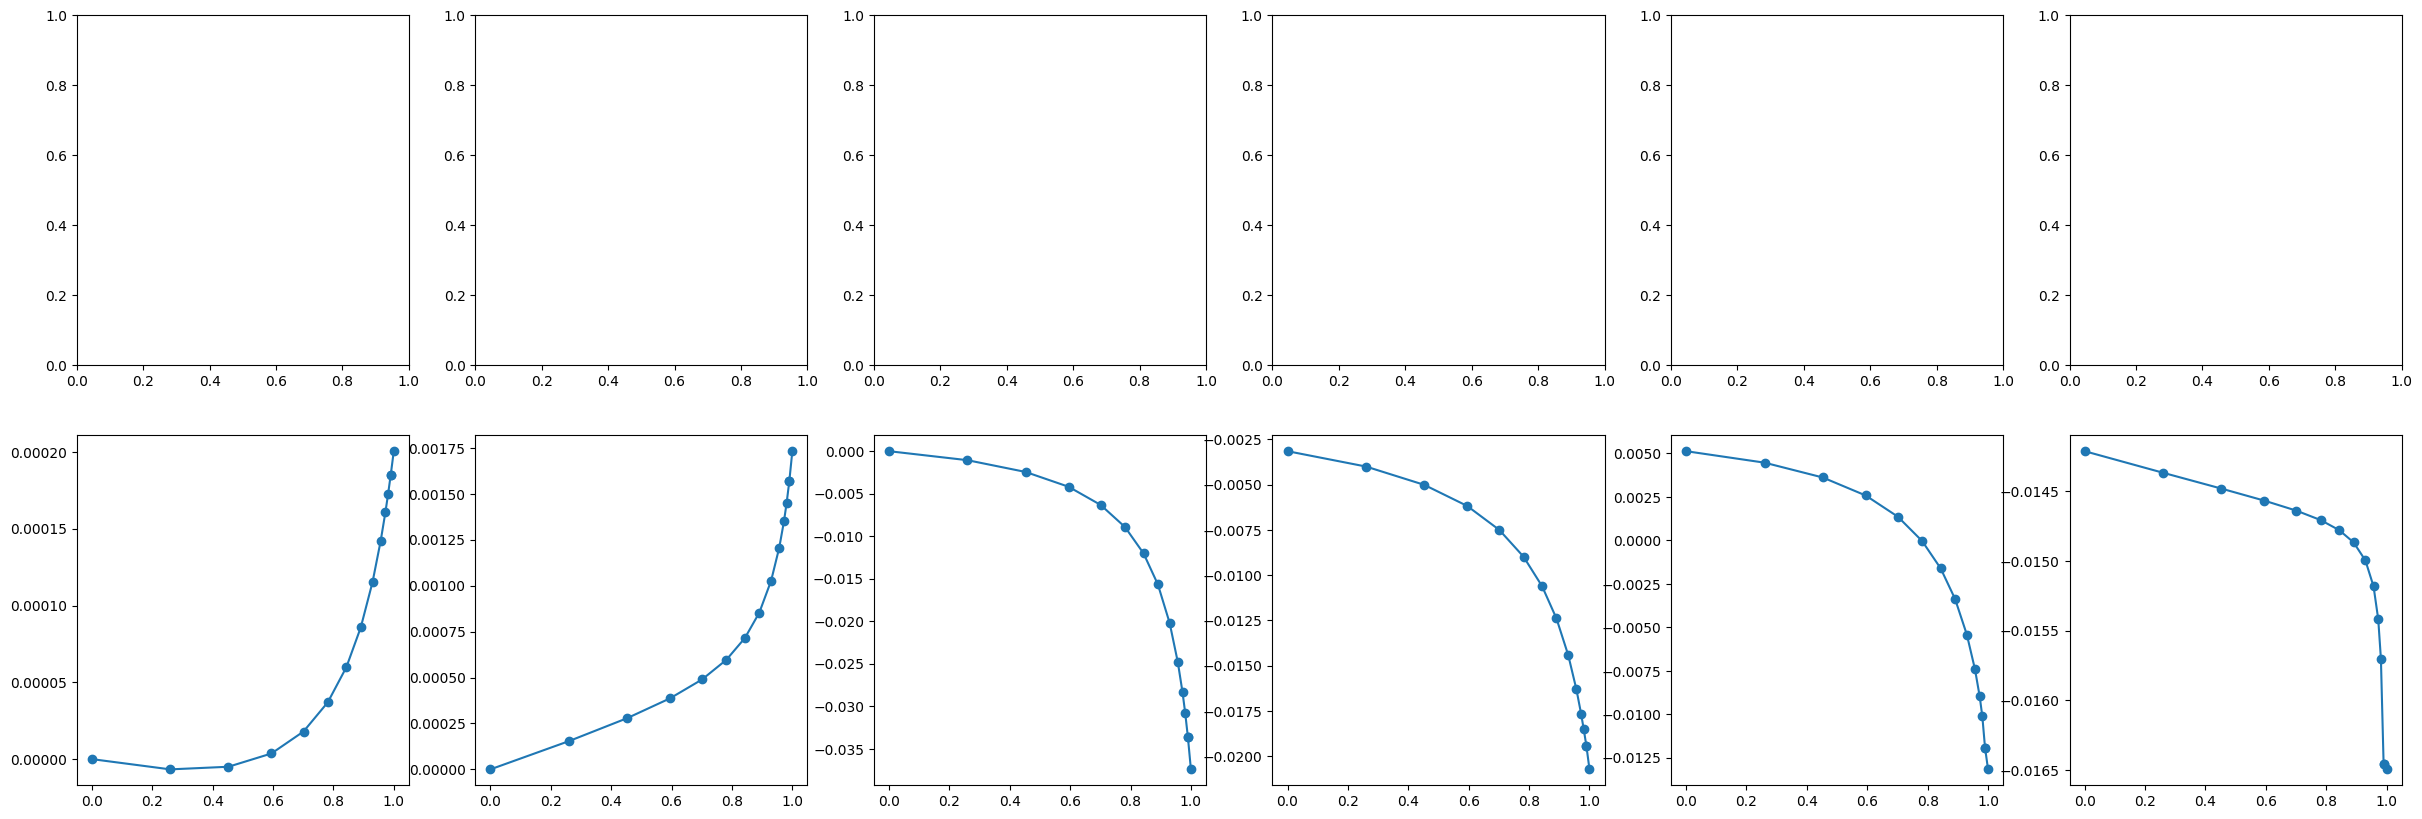

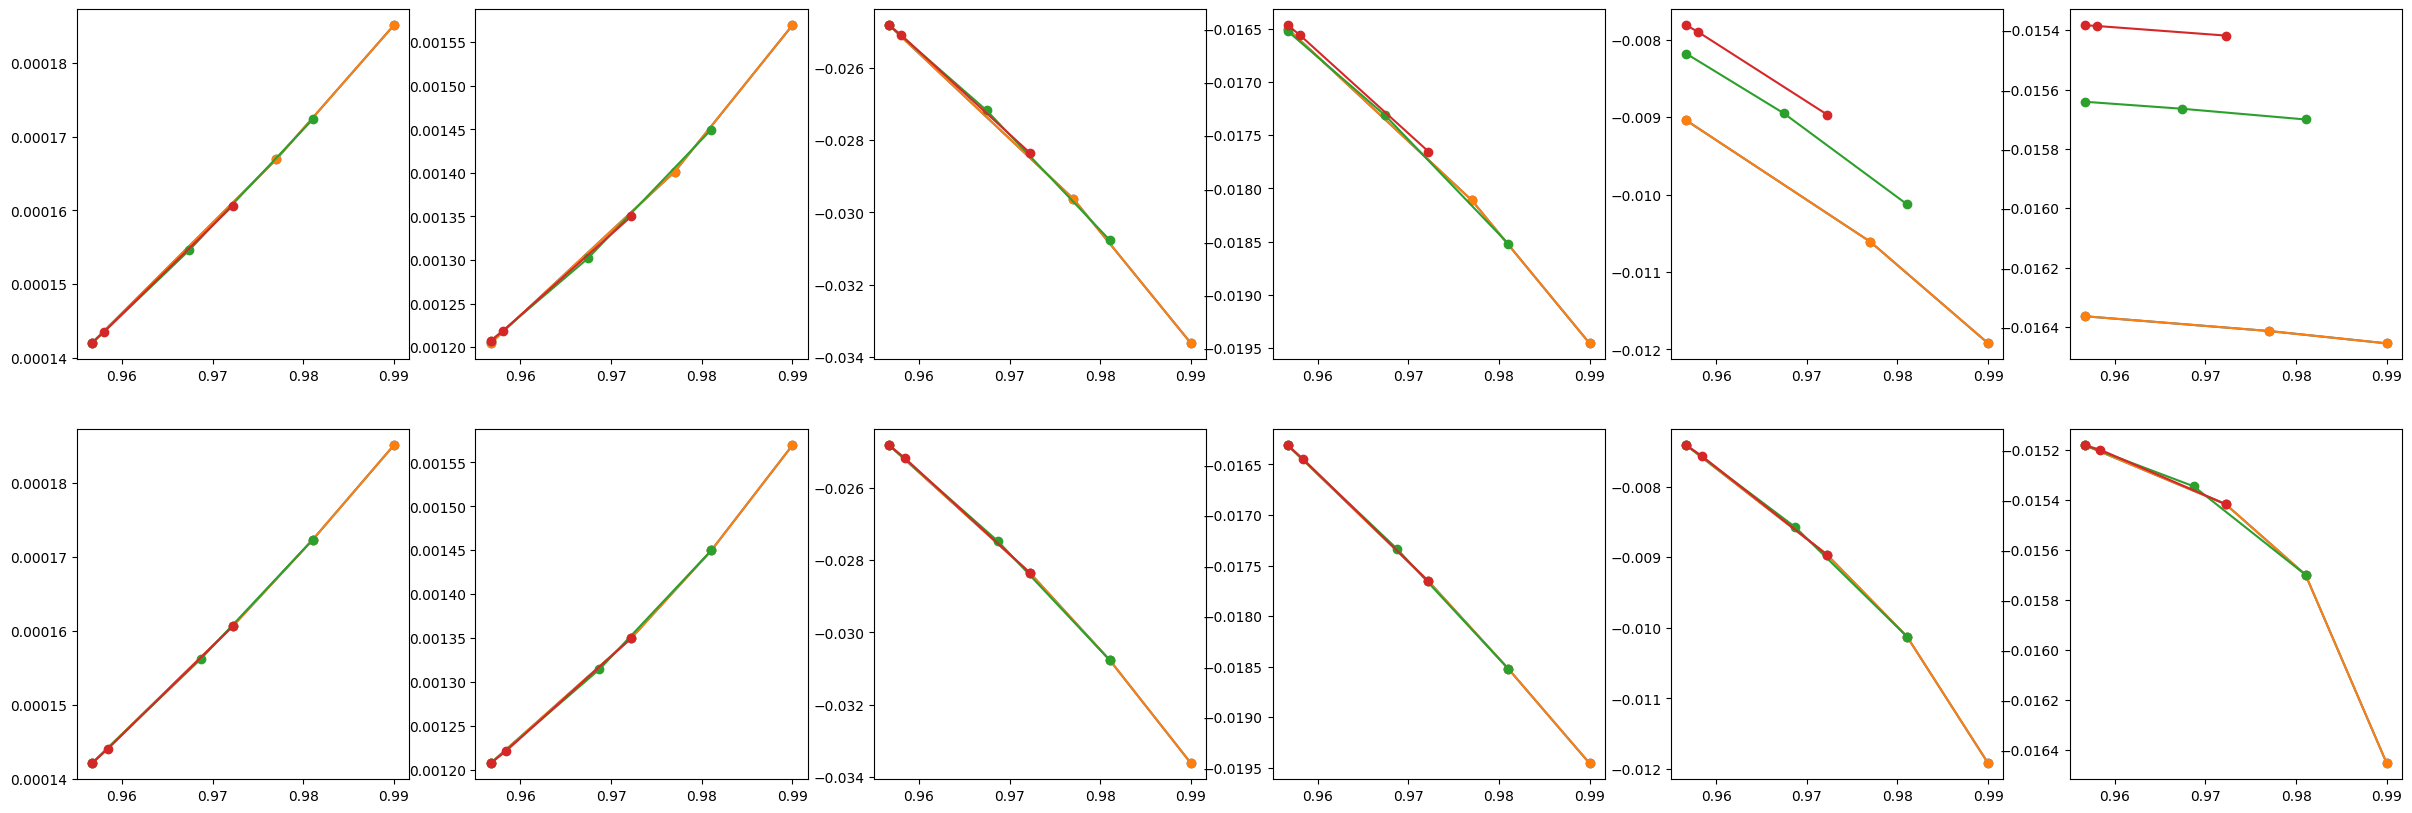

In [48]:

pcswe.FO_bnd = 1e-2
res, sol1_r, sol1_l = pcswe.solve_FO()
print(sol1_r.t)
print(sol1_l.t)
msol1 = MergedSol(sol1_r, sol1_l)
msol = msol1


fig, axs = plt.subplots(2, 6, figsize=(30, 10))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]

for i in range(6):
    axs[1, i].plot(msol.t, msol.y[i], 'o-')
plt.show()



fig, axs = plt.subplots(2, 6, figsize=(30, 10))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]


n = 5
for i in range(1, n):
    x_range = [msol.t[i], msol.t[n]]
    y1_r = msol.y[:, i]

    sol = scipy.integrate.solve_ivp(pcswe.deriv_FO_hop, x_range, y1_r, rtol=1e-7, atol=1e-7)

    for i in range(6):
        axs[0, i].plot(sol.t, sol.y[i], 'o-')


for i in range(1, n):
    x_range = [msol.t[i], msol.t[n]]
    y1_r = msol.y[:, i]

    sol = scipy.integrate.solve_ivp(pcswe.deriv_FO, x_range, y1_r, rtol=1e-7, atol=1e-7)

    for i in range(6):
        axs[1, i].plot(sol.t, sol.y[i], 'o-')
        
plt.show()

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.564e-18 -5.421e-19 -3.361e-17]
       x: [ 2.005e-04  1.732e-03 -3.742e-02]
  method: hybr
    nfev: 9
    fjac: [[-1.000e+00  1.620e-07  3.860e-07]
           [-1.465e-07 -9.992e-01  3.991e-02]
           [-3.922e-07 -3.991e-02 -9.992e-01]]
       r: [-1.000e+00  2.062e-07  3.233e-07 -9.297e-01  5.874e-08
           -9.297e-01]
     qtf: [ 2.220e-15 -1.436e-14 -1.687e-14]
[1.   0.99]
[0.99       0.98104907 0.97223302 0.95670372 0.92965524 0.89066478
 0.84300305 0.78151945 0.7011368  0.5948227  0.45255404 0.25981716
 0.        ]
(6, 15)


AssertionError: 

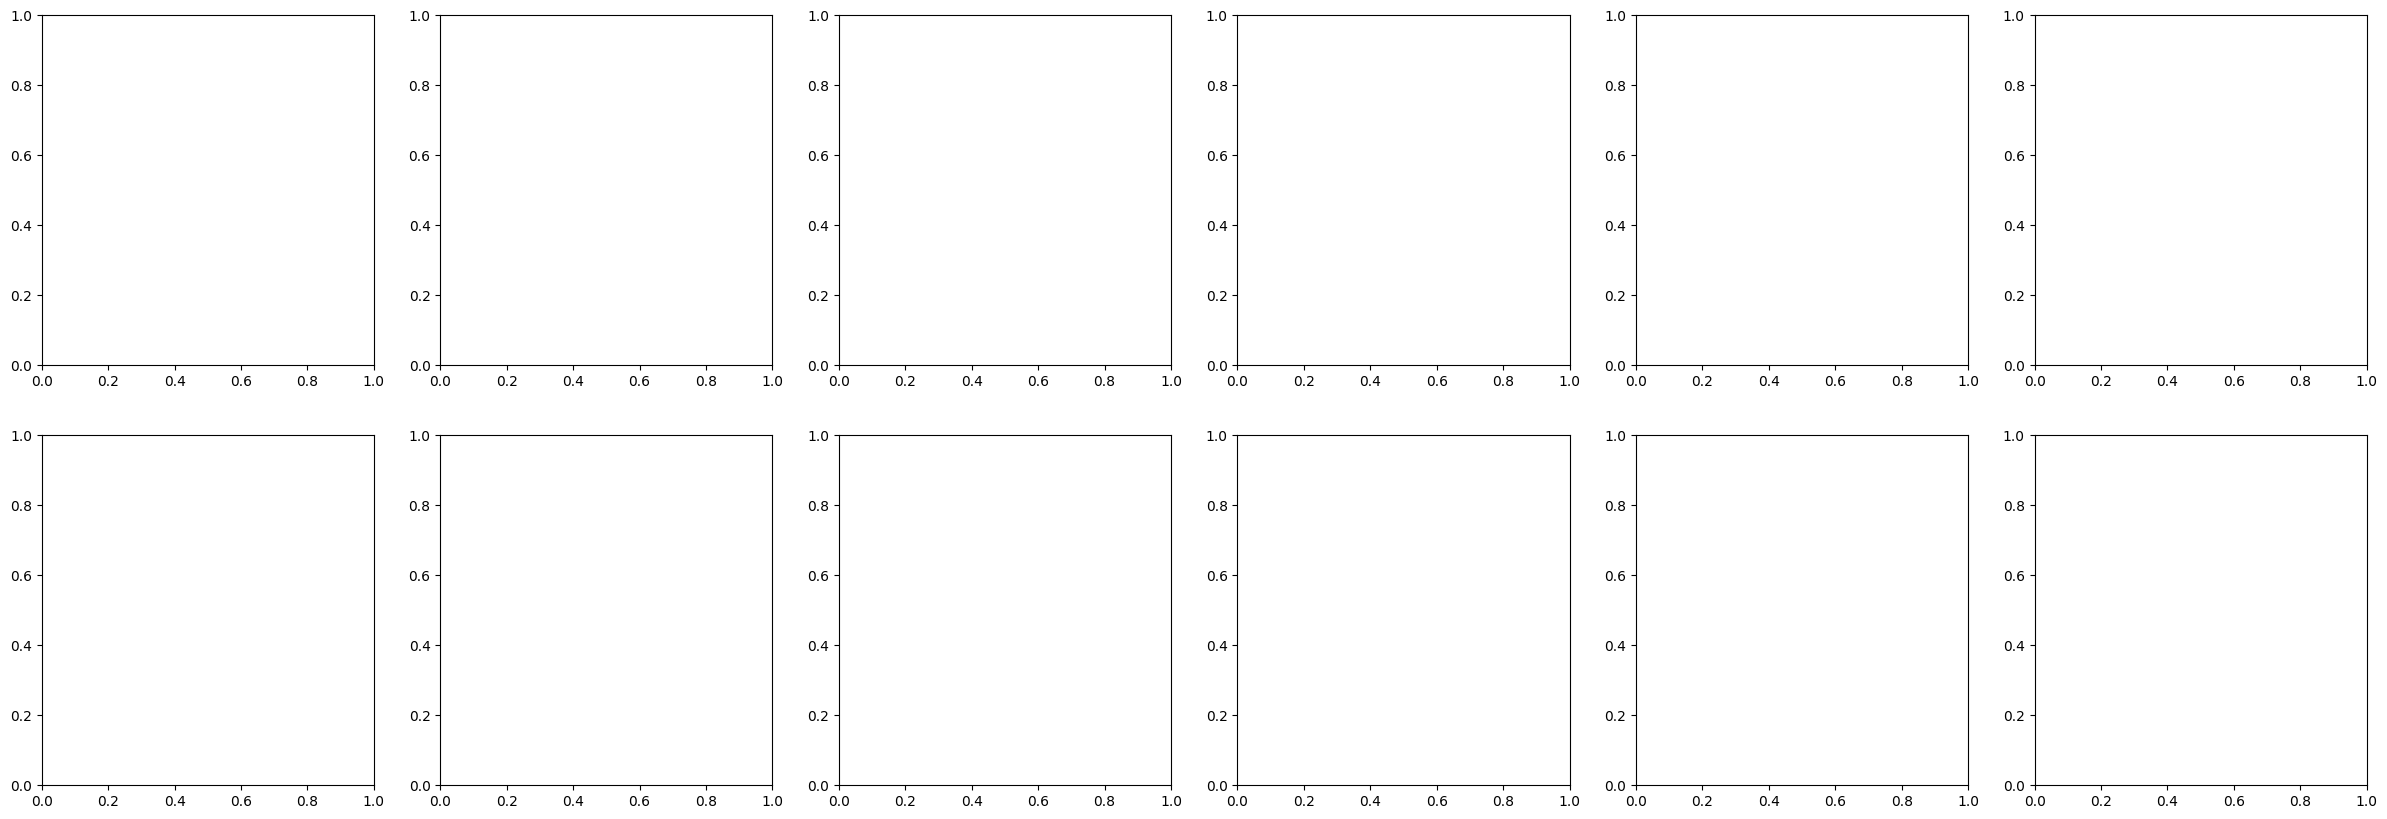

In [41]:

pcswe.FO_bnd = 1e-2
res, sol1_r, sol1_l = pcswe.solve_FO()
print(sol1_r.t)
print(sol1_l.t)
msol2 = MergedSol(sol1_r, sol1_l)
msol = msol2

fig, axs = plt.subplots(2, 6, figsize=(30, 10))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]

for i in range(1, 10):
    x_range = [msol.t[i], msol.t[10]]
    y1_r = msol.y[:, i]

    sol = scipy.integrate.solve_ivp(pcswe.deriv_FO_hop, x_range, y1_r, rtol=1e-7, atol=1e-7)

    for i in range(6):
        axs[0, i].plot(sol.t, sol.y[i], 'o-')


for i in range(1, 10):
    x_range = [msol.t[i], msol.t[10]]
    y1_r = msol.y[:, i]

    sol = scipy.integrate.solve_ivp(pcswe.deriv_FO, x_range, y1_r, rtol=1e-7, atol=1e-7)

    for i in range(6):
        axs[1, i].plot(sol.t, sol.y[i], 'o-')
        
plt.show()

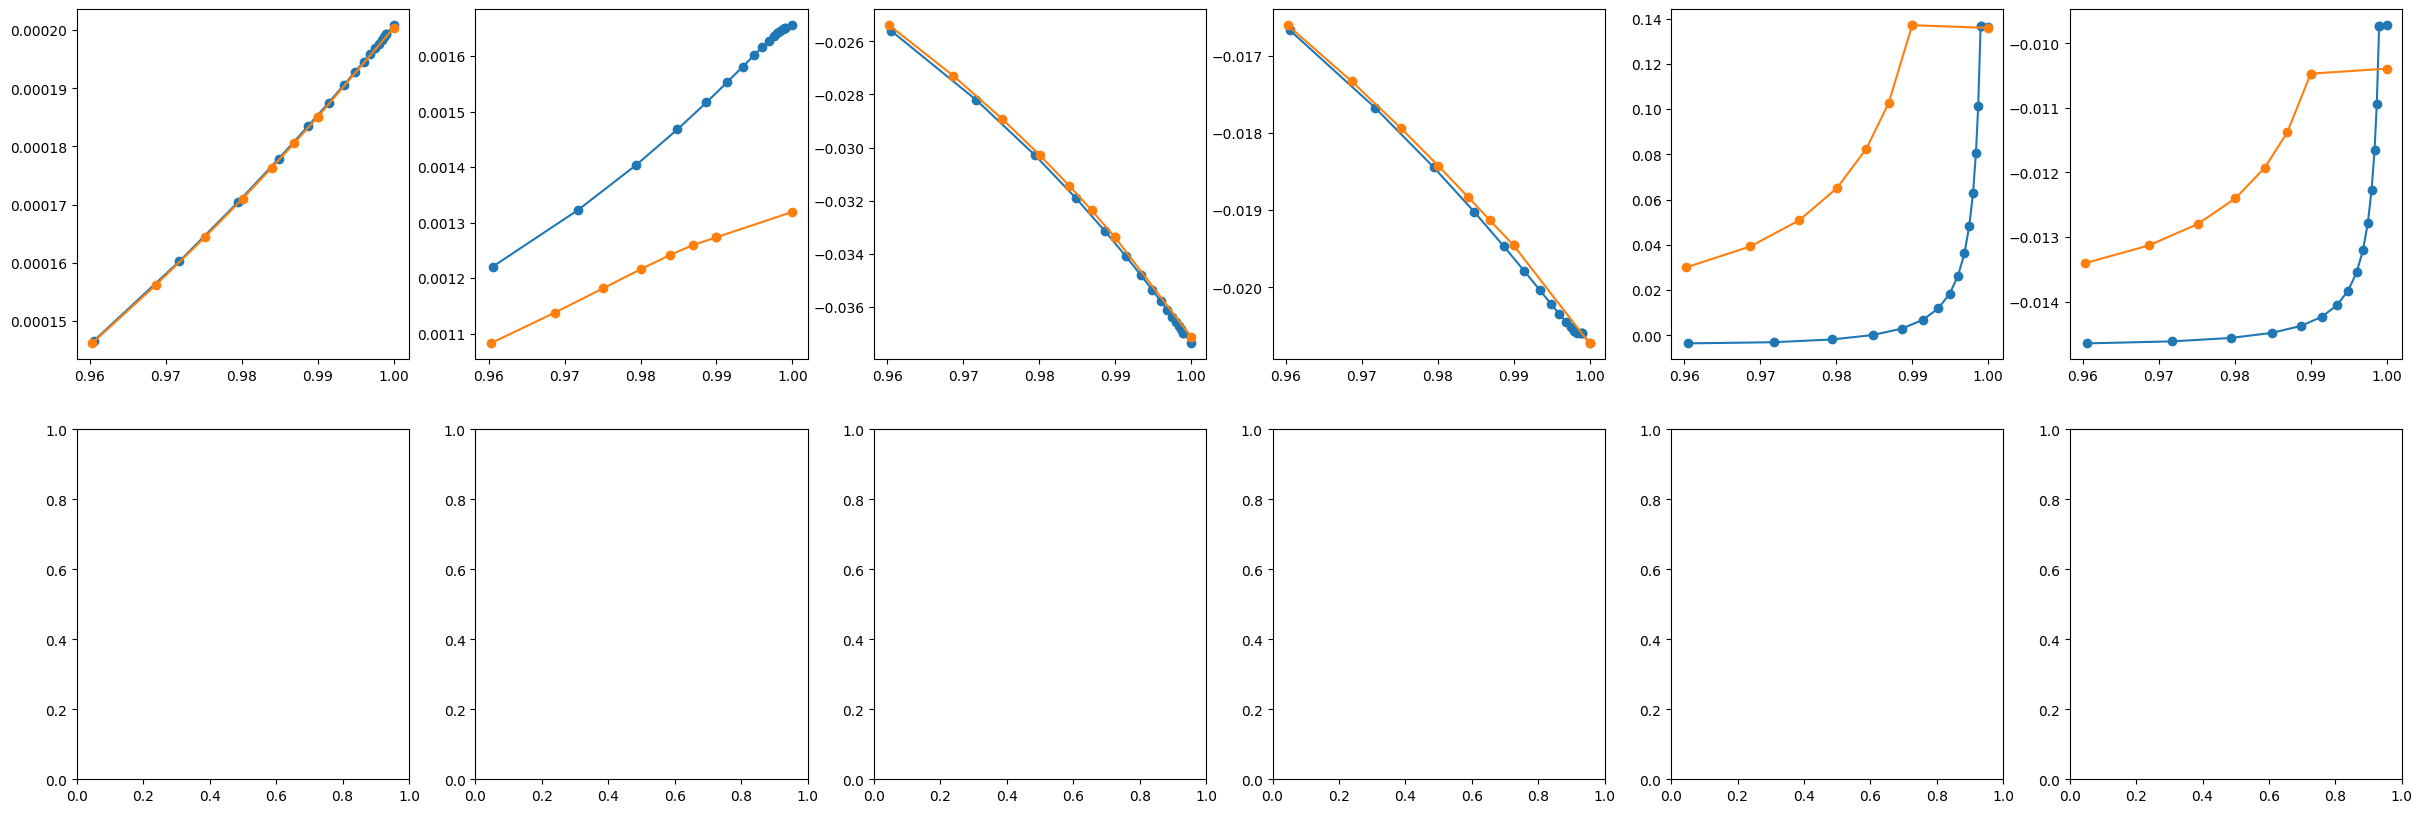

In [ ]:
# compare the two solutions


fig, axs = plt.subplots(2, 6, figsize=(30, 10))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]


bnd = 0.95
x1 = msol1.t[msol1.t > bnd]
y1 = msol1.y[:, msol1.t > bnd]
x2 = msol2.t[msol2.t > bnd]
y2 = msol2.y[:, msol2.t > bnd]

for i in range(6):
    axs[0, i].plot(x1, y1[i], 'o-')
    axs[0, i].plot(x2, y2[i], 'o-')

# for i in range(6):
#     axs[1, i].plot(sol.t, sol.y[i], 'o-')
    
plt.show()